In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Flatten, TimeDistributed, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from glob import glob
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, auc
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Activation, Multiply
from tensorflow.keras import backend as K
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.utils import Sequence

In [4]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.test.is_gpu_available()

False

In [5]:
from tensorflow.keras.layers import Layer, Dense, Activation, Multiply, Lambda
import tensorflow.keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape: (batch_size, timesteps, features)
        self.W = self.add_weight(name='att_weight', 
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='glorot_uniform',
                                 trainable=True)
        self.b = self.add_weight(name='att_bias', 
                                 shape=(input_shape[-1],),
                                 initializer='zeros',
                                 trainable=True)
        self.V = self.add_weight(name='att_var', 
                                 shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        # inputs: (batch_size, timesteps, features)
        # Score calculation for each time step
        score = K.tanh(K.dot(inputs, self.W) + self.b)  # (batch_size, timesteps, features)
        score = K.dot(score, self.V)  # (batch_size, timesteps, 1)
        attention_weights = K.softmax(score, axis=1)  # (batch_size, timesteps, 1)
        
        # Multiply each time step by its attention weight
        context_vector = inputs * attention_weights  # (batch_size, timesteps, features)
        context_vector = K.sum(context_vector, axis=1)   # (batch_size, features)
        return context_vector

# Convenience function to use the layer
def attention_layer(inputs):
    return AttentionLayer()(inputs)


In [6]:
def build_model(input_shape=(299, 299, 9)):
    """
    Builds an improved Xception-based spatial feature extractor and a Bidirectional LSTM
    for temporal analysis with pooling layers and batch normalization.
    """
    print("Building improved model...")

    # Spatial Feature Extractor
    base_model = Xception(include_top=False, weights=None, input_shape=input_shape)

    # Use GlobalAveragePooling2D to aggregate the spatial features.
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization()(x)
    spatial_model = Model(inputs=base_model.input, outputs=x, name="spatial_model")

    # Temporal Analysis with LSTM (Improved)
    lstm_input = Input(shape=(None, 512), name="lstm_input")

    # First LSTM remains the same:
    lstm_out = Bidirectional(LSTM(256, return_sequences=True, dropout=0.4, recurrent_dropout=0.2))(lstm_input)
    # Change the second LSTM to output sequences (i.e., 3D tensor)
    lstm_out = Bidirectional(LSTM(128, return_sequences=True, dropout=0.4))(lstm_out)

    # Now attention_layer receives a 3D tensor as expected
    attn_out = attention_layer(lstm_out)
    attn_out = BatchNormalization()(attn_out)

    output = Dense(1, activation='sigmoid')(attn_out)
    temporal_model = Model(inputs=lstm_input, outputs=output, name="temporal_model")

    print("Improved model built successfully.")
    return spatial_model, temporal_model


def train_model(spatial_model, temporal_model, x_train, y_train, x_test, y_test, epochs=100, batch_size=32):
    """Trains the model with improved training strategy."""
    print("Extracting features from Xception (Spatial Model)...")

    # Extract features from Xception
    x_train_features = spatial_model.predict(x_train)
    x_test_features = spatial_model.predict(x_test)

    # Reshape for LSTM
    x_train_features = np.expand_dims(x_train_features, axis=1)
    x_test_features = np.expand_dims(x_test_features, axis=1)

    # Compile the LSTM (Temporal Model)
    temporal_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    print("Training Improved Temporal Model (LSTM)...")

    # Callbacks
    model_checkpoint = ModelCheckpoint(
        filepath="best_model.h5",
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=False,
        mode="max",
        verbose=1
    )

    early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

    lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)

    # Train the LSTM Model
    history = temporal_model.fit(
        x_train_features, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test_features, y_test),
        callbacks=[model_checkpoint, early_stopping, lr_reducer]
    )

    print("Training completed.")

    # Predict on test set
    y_pred = temporal_model.predict(x_test_features)

    # Evaluate model
    plot_metrics(history, y_test, y_pred)


def plot_metrics(history, y_test, y_pred):
    """Plots training metrics, evaluation metrics, ROC curve, and precision-recall curve."""
    # Training Loss and Accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training vs Validation Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.show()
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

    # Compute ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Compute Precision-Recall Curve and AUC
    precision, recall, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall, precision)
    
    # Plot Precision-Recall Curve
    plt.figure()
    plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
    plt.show()
    
    # Print evaluation metrics
    y_pred_binary = (y_pred > 0.5).astype(int)
    print(f'Accuracy Score: {accuracy_score(y_test, y_pred_binary):.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}')
    print(f'Recall Score: {recall_score(y_test, y_pred_binary):.4f}')
    print(f'Precision Score: {precision_score(y_test, y_pred_binary):.4f}')
    print(f'F1 Score: {f1_score(y_test, y_pred_binary):.4f}')
    print(f'PR AUC Score: {pr_auc:.4f}')
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred_binary))

In [7]:
# # Load precomputed dataset
# save_path = "E:/dataset_1/preprocessed_happy.npz"
# print(f"📂 Loading precomputed dataset from {save_path}...")
# data = np.load(save_path)

# # Extract x_data and y_data
# x_data, y_data = data["x"], data["y"]
# print(f"✅ Loaded dataset: {x_data.shape[0]} samples.")

# # Train-test split
# x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# # Verify shapes
# print(f"📊 Train/Test Split:")
# print(f"  x_train: {x_train.shape}, y_train: {y_train.shape}")
# print(f"  x_test: {x_test.shape}, y_test: {y_test.shape}")

In [8]:



# Create a Sequence wrapper to load batches from the memmap on demand.
class MemmapSequence(Sequence):
    def __init__(self, memmap_array, indices, batch_size=32):
        self.memmap_array = memmap_array
        self.indices = indices
        self.batch_size = batch_size
        
    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))
    
    def __getitem__(self, idx):
        batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        # When using fancy indexing on a memmap, a copy is made only for this batch.
        return self.memmap_array[batch_idx]

# --- Data Loading Without Loading Entire Dataset Into RAM ---

# Load the dataset with memory mapping so that the full array isn’t loaded into RAM immediately.
save_path = "E:/dataset_1/preprocessed_disgust.npz"
print(f"📂 Loading precomputed dataset from {save_path}...")
data = np.load(save_path, mmap_mode='r')  # memmap; data remains on disk until accessed
x_data, y_data = data["x"], data["y"]
print(f"✅ Loaded dataset: {x_data.shape[0]} samples.")

# Use StratifiedShuffleSplit to get train/test indices without forcing a full copy.
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(x_data, y_data))

# Sorting indices can help get more contiguous slices.
train_idx = np.sort(train_idx)
test_idx = np.sort(test_idx)

# Instead of slicing x_data (which would copy a 12GB block into memory),
# create Sequences that load data in batches.
batch_size = 32
x_train_seq = MemmapSequence(x_data, train_idx, batch_size=batch_size)
x_test_seq = MemmapSequence(x_data, test_idx, batch_size=batch_size)

# y_data is small so we load it normally.
y_train = y_data[train_idx]
y_test = y_data[test_idx]

print("📊 Train/Test Split:")
print(f"  x_train_seq: {len(x_train_seq)} batches (batch_size={batch_size}), y_train: {y_train.shape}")
print(f"  x_test_seq: {len(x_test_seq)} batches (batch_size={batch_size}), y_test: {y_test.shape}")

# --- Training the Model ---
# Now call your train_model function as before—but pass the Sequence objects instead of full numpy arrays.
# For example:
#
# spatial_model, temporal_model = build_model(input_shape=(299, 299, 9))
# train_model(spatial_model, temporal_model, x_train_seq, y_train, x_test_seq, y_test)
#
# Keras model.predict (and model.fit, if needed) supports Sequence objects, so your existing
# build_model() and train_model() functions remain unchanged.


📂 Loading precomputed dataset from E:/dataset_1/preprocessed_disgust.npz...
✅ Loaded dataset: 20000 samples.
📊 Train/Test Split:
  x_train_seq: 500 batches (batch_size=32), y_train: (16000,)
  x_test_seq: 125 batches (batch_size=32), y_test: (4000,)


In [9]:
# if __name__ == "__main__":
#     real_faces = "E:/Research/real/Cropped_Faces"
#     fake_faces = "E:/Research/fake/Cropped_Faces"
    # real_data, fake_data = prepare_data(real_faces, "", fake_faces, "")
    
    # Build the Spatial and Temporal Models
spatial_model, temporal_model = build_model(input_shape=(299, 299, 9))

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# y_test = y_test.astype('float32')
# y_test = y_test.astype('float32')

# spatial_model.summary()
temporal_model.summary()


Building improved model...


c:\Users\G713QM-\anaconda3\Lib\site-packages\keras\src\applications\xception.py:111: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 9 input channels.
  input_shape = imagenet_utils.obtain_input_shape(



Improved model built successfully.


Model: "temporal_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_input (InputLayer)         │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, None, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 512)      │     1,574,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, None, 256)      │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 256)            │        66,048 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,298,625 (8.77 MB)

 Trainable params: 2,298,113 (8.77 MB)

 Non-trainable params: 512 (2.00 KB)

Extracting features from Xception (Spatial Model)...


c:\Users\G713QM-\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 1865s 4s/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 478s 4s/step
Training Improved Temporal Model (LSTM)...
Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5086 - loss: 0.6931
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 22ms/step - accuracy: 0.5086 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 2/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5661 - loss: 0.6916
Epoch 2: val_accuracy improved from 0.50000 to 0.64500, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.5662 - loss: 0.6916 - val_accuracy: 0.6450 - val_loss: 0.6864 - learning_rate: 1.0000e-04
Epoch 3/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6551 - loss: 0.6817
Epoch 3: val_accuracy improved from 0.64500 to 0.88725, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.6552 - loss: 0.6817 - val_accuracy: 0.8873 - val_loss: 0.6479 - learning_rate: 1.0000e-04
Epoch 4/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7460 - loss: 0.6283
Epoch 4: val_accuracy did not improve from 0.88725
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.7461 - loss: 0.6282 - val_accuracy: 0.8353 - val_loss: 0.5104 - learning_rate: 1.0000e-04
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8293 - loss: 0.4831
Epoch 5: val_accuracy did not improve from 0.88725
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8293 - loss: 0.4830 - val_accuracy: 0.8808 - val_loss: 0.3641 - learning_rate: 1.0000e-04
Epoch 6/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8675 - loss: 0.3626
Epoch 6: val_accuracy improved from 0.88725 to 0.88750, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8675 - loss: 0.3626 - val_accuracy: 0.8875 - val_loss: 0.3176 - learning_rate: 1.0000e-04
Epoch 7/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8669 - loss: 0.3454
Epoch 7: val_accuracy improved from 0.88750 to 0.89475, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8669 - loss: 0.3453 - val_accuracy: 0.8947 - val_loss: 0.2967 - learning_rate: 1.0000e-04
Epoch 8/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8645 - loss: 0.3451
Epoch 8: val_accuracy did not improve from 0.89475
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8645 - loss: 0.3450 - val_accuracy: 0.8917 - val_loss: 0.2950 - learning_rate: 1.0000e-04
Epoch 9/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8686 - loss: 0.3400
Epoch 9: val_accuracy did not improve from 0.89475
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8686 - loss: 0.3399 - val_accuracy: 0.8928 - val_loss: 0.2937 - learning_rate: 1.0000e-04
Epoch 10/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8713 - loss: 0.3205
Epoch 10: val_accuracy improved from 0.89475 to 0.90275, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8713 - loss: 0.3205 - val_accuracy: 0.9028 - val_loss: 0.2742 - learning_rate: 1.0000e-04
Epoch 11/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8710 - loss: 0.3235
Epoch 11: val_accuracy improved from 0.90275 to 0.90525, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8710 - loss: 0.3235 - val_accuracy: 0.9053 - val_loss: 0.2709 - learning_rate: 1.0000e-04
Epoch 12/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8777 - loss: 0.3148
Epoch 12: val_accuracy did not improve from 0.90525
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8777 - loss: 0.3148 - val_accuracy: 0.8985 - val_loss: 0.2735 - learning_rate: 1.0000e-04
Epoch 13/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8757 - loss: 0.3147
Epoch 13: val_accuracy improved from 0.90525 to 0.90775, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8757 - loss: 0.3148 - val_accuracy: 0.9078 - val_loss: 0.2675 - learning_rate: 1.0000e-04
Epoch 14/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8767 - loss: 0.3118
Epoch 14: val_accuracy did not improve from 0.90775
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8768 - loss: 0.3118 - val_accuracy: 0.8972 - val_loss: 0.2712 - learning_rate: 1.0000e-04
Epoch 15/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8800 - loss: 0.3058
Epoch 15: val_accuracy improved from 0.90775 to 0.91000, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8800 - loss: 0.3058 - val_accuracy: 0.9100 - val_loss: 0.2621 - learning_rate: 1.0000e-04
Epoch 16/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8819 - loss: 0.3093
Epoch 16: val_accuracy did not improve from 0.91000
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8819 - loss: 0.3093 - val_accuracy: 0.8950 - val_loss: 0.2725 - learning_rate: 1.0000e-04
Epoch 17/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8855 - loss: 0.3022
Epoch 17: val_accuracy did not improve from 0.91000
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8855 - loss: 0.3022 - val_accuracy: 0.9062 - val_loss: 0.2616 - learning_rate: 1.0000e-04
Epoch 18/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8842 - loss: 0.3016
Epoch 18: val_accuracy improved from 0.91000 to 0.91300, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8842 - loss: 0.3016 - val_accuracy: 0.9130 - val_loss: 0.2549 - learning_rate: 1.0000e-04
Epoch 19/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8837 - loss: 0.2949
Epoch 19: val_accuracy improved from 0.91300 to 0.91900, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8837 - loss: 0.2949 - val_accuracy: 0.9190 - val_loss: 0.2505 - learning_rate: 1.0000e-04
Epoch 20/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8823 - loss: 0.3102
Epoch 20: val_accuracy improved from 0.91900 to 0.91950, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8823 - loss: 0.3102 - val_accuracy: 0.9195 - val_loss: 0.2484 - learning_rate: 1.0000e-04
Epoch 21/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8919 - loss: 0.2912
Epoch 21: val_accuracy did not improve from 0.91950
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8919 - loss: 0.2912 - val_accuracy: 0.9180 - val_loss: 0.2489 - learning_rate: 1.0000e-04
Epoch 22/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8893 - loss: 0.2916
Epoch 22: val_accuracy improved from 0.91950 to 0.92400, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8893 - loss: 0.2916 - val_accuracy: 0.9240 - val_loss: 0.2430 - learning_rate: 1.0000e-04
Epoch 23/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8930 - loss: 0.2935
Epoch 23: val_accuracy did not improve from 0.92400
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8930 - loss: 0.2934 - val_accuracy: 0.9080 - val_loss: 0.2592 - learning_rate: 1.0000e-04
Epoch 24/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8937 - loss: 0.2845
Epoch 24: val_accuracy did not improve from 0.92400
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8937 - loss: 0.2846 - val_accuracy: 0.9155 - val_loss: 0.2456 - learning_rate: 1.0000e-04
Epoch 25/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8926 - loss: 0.2866
Epoch 25: val_accuracy did not improve from 0.92400
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8926 - loss: 0.2866 - val_accuracy: 0.9060 - val_loss: 0.2620 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8921 - loss: 0.2759 - val_accuracy: 0.9320 - val_loss: 0.2309 - learning_rate: 1.0000e-04
Epoch 28/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8984 - loss: 0.2836
Epoch 28: val_accuracy did not improve from 0.93200
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8984 - loss: 0.2835 - val_accuracy: 0.9265 - val_loss: 0.2338 - learning_rate: 1.0000e-04
Epoch 29/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9025 - loss: 0.2744
Epoch 29: val_accuracy did not improve from 0.93200
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9025 - loss: 0.2745 - val_accuracy: 0.9280 - val_loss: 0.2313 - learning_rate: 1.0000e-04
Epoch 30/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8977 - loss: 0.2774
Epoch 30: val_accuracy did not improve from 0.93200
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8977 - loss: 0.2774 - val_accuracy: 0.9310 - val_loss: 0.2257 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9011 - loss: 0.2705 - val_accuracy: 0.9373 - val_loss: 0.2193 - learning_rate: 1.0000e-04
Epoch 33/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8967 - loss: 0.2797
Epoch 33: val_accuracy improved from 0.93725 to 0.93825, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8967 - loss: 0.2797 - val_accuracy: 0.9383 - val_loss: 0.2169 - learning_rate: 1.0000e-04
Epoch 34/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8996 - loss: 0.2649
Epoch 34: val_accuracy did not improve from 0.93825
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8996 - loss: 0.2649 - val_accuracy: 0.9348 - val_loss: 0.2162 - learning_rate: 1.0000e-04
Epoch 35/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9037 - loss: 0.2657
Epoch 35: val_accuracy improved from 0.93825 to 0.94075, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9037 - loss: 0.2658 - val_accuracy: 0.9408 - val_loss: 0.2117 - learning_rate: 1.0000e-04
Epoch 36/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9073 - loss: 0.2507
Epoch 36: val_accuracy improved from 0.94075 to 0.94250, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9073 - loss: 0.2507 - val_accuracy: 0.9425 - val_loss: 0.2092 - learning_rate: 1.0000e-04
Epoch 37/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9082 - loss: 0.2582
Epoch 37: val_accuracy did not improve from 0.94250
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9082 - loss: 0.2582 - val_accuracy: 0.9425 - val_loss: 0.2077 - learning_rate: 1.0000e-04
Epoch 38/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9070 - loss: 0.2630
Epoch 38: val_accuracy did not improve from 0.94250
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9070 - loss: 0.2629 - val_accuracy: 0.9370 - val_loss: 0.2115 - learning_rate: 1.0000e-04
Epoch 39/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9087 - loss: 0.2649
Epoch 39: val_accuracy did not improve from 0.94250
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9087 - loss: 0.2649 - val_accuracy: 0.9383 - val_loss: 0.2106 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9071 - loss: 0.2532 - val_accuracy: 0.9460 - val_loss: 0.1977 - learning_rate: 1.0000e-04
Epoch 42/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9132 - loss: 0.2456
Epoch 42: val_accuracy did not improve from 0.94600
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9132 - loss: 0.2456 - val_accuracy: 0.9350 - val_loss: 0.2109 - learning_rate: 1.0000e-04
Epoch 43/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9164 - loss: 0.2403
Epoch 43: val_accuracy did not improve from 0.94600
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - accuracy: 0.9164 - loss: 0.2403 - val_accuracy: 0.9325 - val_loss: 0.2089 - learning_rate: 1.0000e-04
Epoch 44/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9132 - loss: 0.2478
Epoch 44: val_accuracy improved from 0.94600 to 0.94625, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9132 - loss: 0.2478 - val_accuracy: 0.9463 - val_loss: 0.1928 - learning_rate: 1.0000e-04
Epoch 45/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9158 - loss: 0.2389
Epoch 45: val_accuracy did not improve from 0.94625
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9158 - loss: 0.2390 - val_accuracy: 0.9463 - val_loss: 0.1913 - learning_rate: 1.0000e-04
Epoch 46/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9177 - loss: 0.2346
Epoch 46: val_accuracy did not improve from 0.94625
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9177 - loss: 0.2346 - val_accuracy: 0.9395 - val_loss: 0.1986 - learning_rate: 1.0000e-04
Epoch 47/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9180 - loss: 0.2355
Epoch 47: val_accuracy improved from 0.94625 to 0.95125, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9180 - loss: 0.2356 - val_accuracy: 0.9513 - val_loss: 0.1850 - learning_rate: 1.0000e-04
Epoch 48/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9133 - loss: 0.2422
Epoch 48: val_accuracy did not improve from 0.95125
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9133 - loss: 0.2422 - val_accuracy: 0.9510 - val_loss: 0.1821 - learning_rate: 1.0000e-04
Epoch 49/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9186 - loss: 0.2492
Epoch 49: val_accuracy did not improve from 0.95125
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9186 - loss: 0.2491 - val_accuracy: 0.9258 - val_loss: 0.2228 - learning_rate: 1.0000e-04
Epoch 50/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9215 - loss: 0.2408
Epoch 50: val_accuracy did not improve from 0.95125
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9215 - loss: 0.2407 - val_accuracy: 0.9470 - val_loss: 0.1875 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.9234 - loss: 0.2262 - val_accuracy: 0.9557 - val_loss: 0.1717 - learning_rate: 1.0000e-04
Epoch 54/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9186 - loss: 0.2372
Epoch 54: val_accuracy did not improve from 0.95575
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9186 - loss: 0.2372 - val_accuracy: 0.9390 - val_loss: 0.1901 - learning_rate: 1.0000e-04
Epoch 55/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9193 - loss: 0.2343
Epoch 55: val_accuracy did not improve from 0.95575
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9193 - loss: 0.2343 - val_accuracy: 0.9495 - val_loss: 0.1762 - learning_rate: 1.0000e-04
Epoch 56/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9230 - loss: 0.2450
Epoch 56: val_accuracy improved from 0.95575 to 0.95650, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9230 - loss: 0.2449 - val_accuracy: 0.9565 - val_loss: 0.1708 - learning_rate: 1.0000e-04
Epoch 57/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9197 - loss: 0.2280
Epoch 57: val_accuracy did not improve from 0.95650
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9197 - loss: 0.2280 - val_accuracy: 0.9550 - val_loss: 0.1661 - learning_rate: 1.0000e-04
Epoch 58/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9236 - loss: 0.2322
Epoch 58: val_accuracy did not improve from 0.95650
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9236 - loss: 0.2322 - val_accuracy: 0.9398 - val_loss: 0.1867 - learning_rate: 1.0000e-04
Epoch 59/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9232 - loss: 0.2213
Epoch 59: val_accuracy did not improve from 0.95650
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9232 - loss: 0.2213 - val_accuracy: 0.9467 - val_loss: 0.1956 - learning_rate: 

500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9231 - loss: 0.2212 - val_accuracy: 0.9592 - val_loss: 0.1570 - learning_rate: 5.0000e-05
Epoch 66/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9297 - loss: 0.2163
Epoch 66: val_accuracy improved from 0.95925 to 0.96200, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9297 - loss: 0.2163 - val_accuracy: 0.9620 - val_loss: 0.1599 - learning_rate: 5.0000e-05
Epoch 67/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9346 - loss: 0.1996
Epoch 67: val_accuracy did not improve from 0.96200
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9346 - loss: 0.1996 - val_accuracy: 0.9588 - val_loss: 0.1521 - learning_rate: 5.0000e-05
Epoch 68/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9361 - loss: 0.2005
Epoch 68: val_accuracy did not improve from 0.96200
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9361 - loss: 0.2005 - val_accuracy: 0.9603 - val_loss: 0.1617 - learning_rate: 5.0000e-05
Epoch 69/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9352 - loss: 0.1971
Epoch 69: val_accuracy did not improve from 0.96200
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9352 - loss: 0.1972 - val_accuracy: 0.9557 - val_loss: 0.1761 - learning_rate: 5.

500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9307 - loss: 0.2140 - val_accuracy: 0.9625 - val_loss: 0.1536 - learning_rate: 2.5000e-05
Epoch 73/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9366 - loss: 0.2093
Epoch 73: val_accuracy improved from 0.96250 to 0.96400, saving model to best_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9366 - loss: 0.2092 - val_accuracy: 0.9640 - val_loss: 0.1560 - learning_rate: 2.5000e-05
Epoch 74/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9366 - loss: 0.1982
Epoch 74: val_accuracy did not improve from 0.96400
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9366 - loss: 0.1982 - val_accuracy: 0.9625 - val_loss: 0.1498 - learning_rate: 2.5000e-05
Epoch 75/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9363 - loss: 0.2036
Epoch 75: val_accuracy did not improve from 0.96400
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9363 - loss: 0.2036 - val_accuracy: 0.9585 - val_loss: 0.1546 - learning_rate: 2.5000e-05
Epoch 76/100
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9337 - loss: 0.1983
Epoch 76: val_accuracy did not improve from 0.96400
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.9337 - loss: 0.1984 - val_accuracy: 0.9615 - val_loss: 0.1587 - learning_rate: 2

500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9368 - loss: 0.2005 - val_accuracy: 0.9647 - val_loss: 0.1534 - learning_rate: 1.2500e-05
Epoch 80/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9346 - loss: 0.2068
Epoch 80: val_accuracy did not improve from 0.96475
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9346 - loss: 0.2068 - val_accuracy: 0.9647 - val_loss: 0.1530 - learning_rate: 1.2500e-05
Epoch 81/100
498/500 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9353 - loss: 0.1977
Epoch 81: val_accuracy did not improve from 0.96475
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.9353 - loss: 0.1978 - val_accuracy: 0.9647 - val_loss: 0.1549 - learning_rate: 1.2500e-05
Epoch 81: early stopping
Restoring model weights from the end of the best epoch: 74.
Training completed.
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


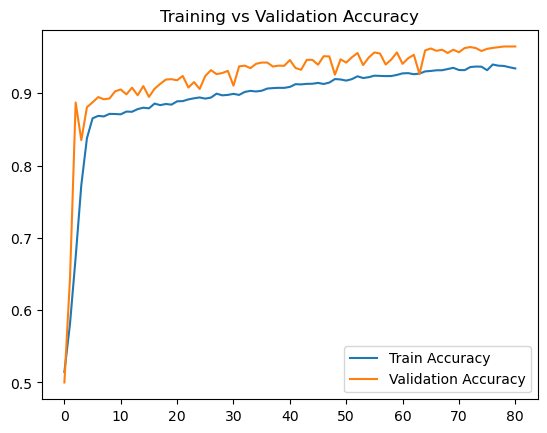

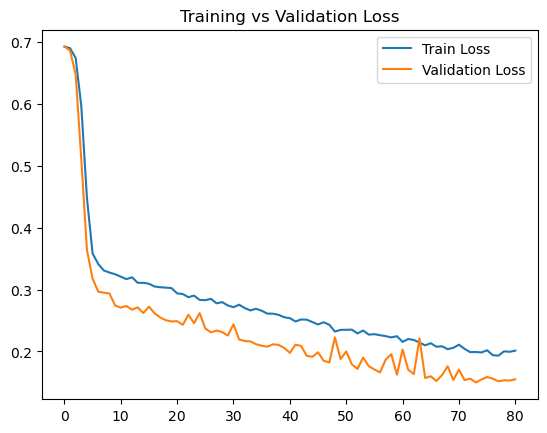

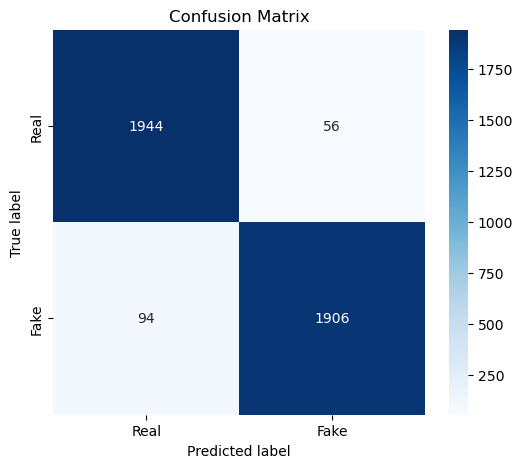

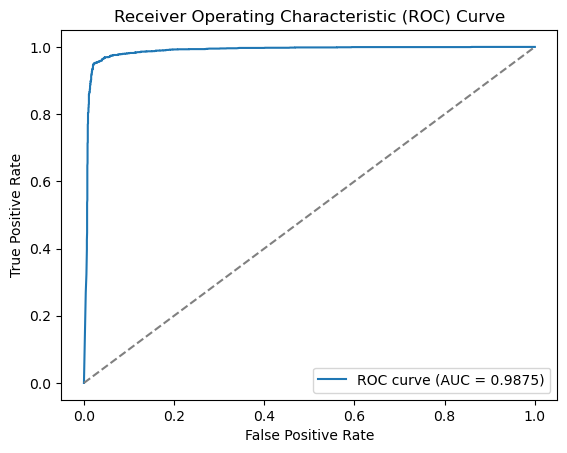

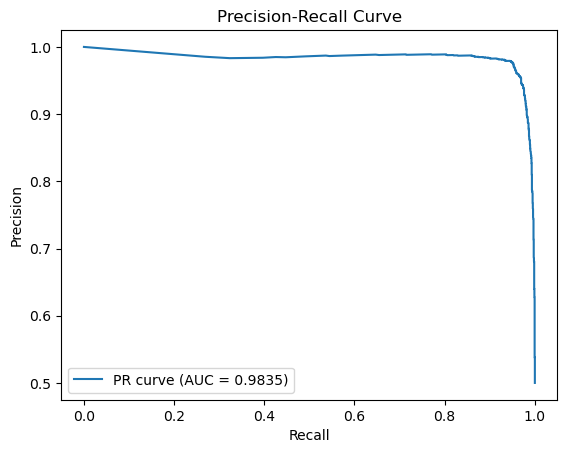

Accuracy Score: 0.9625
ROC AUC Score: 0.9875
Recall Score: 0.9530
Precision Score: 0.9715
F1 Score: 0.9621
PR AUC Score: 0.9835
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2000
           1       0.97      0.95      0.96      2000

    accuracy                           0.96      4000
   macro avg       0.96      0.96      0.96      4000
weighted avg       0.96      0.96      0.96      4000



In [10]:
# Train the Model
train_model(spatial_model, temporal_model, x_train_seq, y_train, x_test_seq, y_test, epochs=100, batch_size=32)